In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random
import math
from pprint import pprint
from google.colab import files
import io

In [ ]:
# @title reading and seperating the file
from google.colab import drive
drive.mount("/content/drive")

data = pd.read_csv('/content/drive/My Drive/A1T2Data.csv',sep=';')

Mounted at /content/drive


In [ ]:
# @title info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

In [ ]:
# @title See null
data.isnull().sum()

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance\t                      0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

No null value preprocessing is done

In [ ]:
dataC = data.copy()

Text(0, 0.5, 'count')

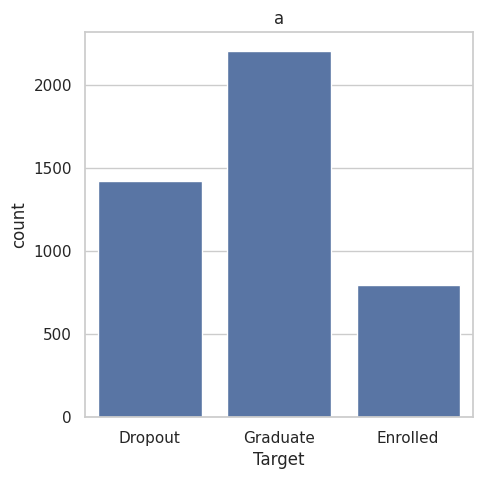

In [ ]:
# @title graph
plt.figure(figsize=(5,5))

plt.title('a',fontsize=12)
sns.set(style='whitegrid')
sns.countplot(x=dataC['Target'])
plt.xlabel('Target',fontsize=12)
plt.ylabel('count',fontsize=12)

function to get simple random sampling

In [ ]:
def train_test_split(data, size, psize):
  if isinstance(size, float):
    size = round(size * len(data))
    psize = round(psize * len(data))

  indices = data.index.tolist()
  test_indices = random.sample(population=indices, k=size)

  indices = [ele for ele in indices if ele not in test_indices]
  prune_indices = random.sample(population=indices, k=psize)

  test = data.loc[test_indices]
  prune = data.loc[prune_indices]
  test_indices.extend(prune_indices)
  train = data.drop(test_indices)

  return train, test, prune

In [ ]:
random.seed(42)
train, test, prune =  train_test_split(dataC,0.3,0.3)

In [ ]:
len(test)

1327

In [ ]:
def binning(data, num_bins=10):
    # Perform binning for each feature
    for feature in data.columns:
        if data[feature].dtype in [np.float64, np.int64]:  # Check if feature is continuous or integer
            data[feature] = pd.cut(data[feature], bins=num_bins, labels=False)
    return data

In [ ]:
train = binning(train)
test = binning(test)

Calc info gain entropy

In [ ]:
def Entropy(data):
    col = data.iloc[:,-1]
    _,counts = np.unique(col, return_counts=True)


    probabilities = counts / counts.sum()
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

In [ ]:
def findEntropy(data):
    col = data[:,-1]
    _,counts = np.unique(col, return_counts=True)


    probabilities = counts / counts.sum()
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

In [ ]:
entropyData = Entropy(train)
print("Entropy of dataset: ", entropyData)

Entropy of dataset:  1.478566971411953


In [ ]:
def split_entropy(left, right):

    # calculate total number of rows
    n = len(left) + len(right)

    # calculate the occurences of each feature
    p_left = len(left) / n
    p_right = len(right) / n

    # calculate weighted entropy
    child_entropy =  (p_left * findEntropy(left) + p_right * findEntropy(right))

    return child_entropy

Calc Gini index

In [ ]:
def calculate_gini(data):

    #calculate gini for target
    class_labels = np.unique(data)

    gini = 0

    for classes in class_labels:

        p_classes = len(data[data == classes]) / len(data)
        gini += p_classes**2

    return 1 - gini

In [ ]:
def calculate_gini_gain(parent, left, right):

    left_weight = len(left) / len(parent)
    right_weight = len(right) / len(parent)

    giniGain = calculate_gini(parent) - (left_weight *calculate_gini(left) + right_weight *calculate_gini(right))

    return giniGain

Calc Gain ratio

In [ ]:
def calcGainRatio(data, left, right):
  infoGain = findEntropy(data)
  splitInfo = split_entropy(left, right)
  gainRatio = infoGain/splitInfo
  return gainRatio

In [ ]:
def get_possible_splits(data):
    possible_splits = {}
    n_rows , n_cols = data.shape
    for col_index in range(n_cols-1):
        possible_splits[col_index] = {}
        values = data[:, col_index]
        unique_values = np.unique(values)

        possible_splits[col_index] = unique_values

    return possible_splits

Binary Splitting

In [ ]:
def split_data(data, split_col, split_val):

    split_col_val = data[:, split_col]

    left = data[split_col_val == split_val]
    right = data[split_col_val !=  split_val]

    return left, right

Calculate best split for info gain

In [ ]:
def determine_best_split(data, possible_splits):

    # calculate the entropy of the data
    parent_entropy = findEntropy(data)
    best_entropy = parent_entropy

    # loop through all values for each column
    for col_index in possible_splits:

        for value in possible_splits[col_index]:

            left, right = split_data(data, split_col=col_index, split_val=value)
            child_entropy = split_entropy(left,right)

            # compare each entropy value and find lowest
            if child_entropy < best_entropy:
                best_split_col = col_index
                best_split_val = value
                best_entropy = child_entropy
                info_gain = parent_entropy - best_entropy

    return best_split_col, best_split_val

Calculate best split for gini index

In [ ]:
def determine_best_split2(data, possible_splits):

    # initialise max gini for comparision
    max_gini_gain = -float("inf")


    #dictionary to store possible splits and corresponding gini index
    gini = {}

    # loop through all values for each column
    for col_index in possible_splits:
        for value in possible_splits[col_index]:

            left, right = split_data(data, split_col=col_index, split_val=value)
            if len(left)>0 and len(right)>0:
                y, left_y, right_y = data[:, -1], left[:, -1], right[:, -1]
                #calculate gini for each feature subset
                curr_gini_gain = calculate_gini_gain(y, left_y, right_y)

                # compare each subset's value
                if curr_gini_gain > max_gini_gain:
                    max_gini_gain = curr_gini_gain
                    best_split_col = col_index
                    best_split_val = value

    return best_split_col, best_split_val

Calculate best split for gain ratio

In [ ]:
def determine_best_split3(data, possible_splits):

    # calculate the entropy of the data
    parent_entropy = findEntropy(data)
    best_entropy = parent_entropy

    #
    best_gain_ratio = 0

    # loop through all values for each column
    for col_index in possible_splits:

        for value in possible_splits[col_index]:

            left, right = split_data(data, split_col=col_index, split_val=value)

            child_entropy = split_entropy(left,right)
            split_info = calculate_Split_info(possible_splits[col_index])

            # get information gain for each feature
            # compare each entropy value and find lowest
            if child_entropy < best_entropy:
                best_entropy = child_entropy
                info_gain = parent_entropy - best_entropy

            #calculate gain ratio
            gain_ratio = info_gain/split_info

            #compare gain ratio
            #feature with highest gain ratio will be used to split
            if gain_ratio > best_gain_ratio:
                best_gain_ratio = gain_ratio
                best_split_col = col_index
                best_split_val = value

    return best_split_col, best_split_val

In [ ]:
def calculate_Split_info(data_col):

    split_info = 0

    unique_vals, n_counts = np.unique(data_col, return_counts=True)
    prob = n_counts / n_counts.sum()

    print(unique_vals)
    print(n_counts)
    print(n_counts.sum())

    for idx, values in enumerate(unique_vals):

        occurences = n_counts[idx]
        prob = occurences/n_counts.sum()
        temp = (prob* - np.log2(prob))
        split_info = split_info + temp

    return(split_info)

In [ ]:
calculate_Split_info(train['Marital status'])

[1 2 3 4 5 6]
[1564  149    2   36   16    3]
1770


0.6606234302293159

Check if it is leaf node

In [ ]:
def check_leaf(data):
    ##store last column as label_col
    label_col = data[:,-1]

    #use np.unique() to extract out unique values from label_col
    classes = np.unique(label_col)

    if len(classes) == 1:
        return True
    else:
        return False;

In [ ]:
np.unique(test.Target, return_counts=True)

(array(['Dropout', 'Enrolled', 'Graduate'], dtype=object),
 array([426, 237, 664]))

In [ ]:
check_leaf(test.values)

False

Find

In [ ]:
def classify_data(data):

    ##since our labels are always in the last column
    label_col = data[:,-1]

    #find each unique targets in the label column and how many times it appears
    targets, n_targets = np.unique(label_col, return_counts=True)

    #find index of the most frequent target
    index = n_targets.argmax()

    #extract out the name
    classification = targets[index]

    return classification

In [ ]:
classify_data(train.values)

'Graduate'

DEcision tree classifier

In [ ]:
def decision_tree_classifier(df, max_depth, min_samples, counter=0):

    ##initialize variables at the start
    if counter == 0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = df.columns
        data = df.values
    else:
        data = df

    # early stopping conditions
    if (check_leaf(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)

        return classification
    else:
        counter += 1
        possible_splits = get_possible_splits(data)

        #use determine_best_split which returns the feature/col with best info gain
        split_column, split_value = determine_best_split(data, possible_splits)

        #split the data according to the result in determine_best_split
        left, right = split_data(data, split_column, split_value)

        # choose question
        feature_name = COLUMN_HEADERS[split_column]

        #format question
        question = "{} = {}".format(feature_name, split_value)

        #initialise dictionary for storing tree
        # method will return this dictionary
        sub_tree = {question: []}

        #recursive call with left and right branches
        yes_answer = decision_tree_classifier(left, max_depth , min_samples, counter)
        no_answer = decision_tree_classifier(right, max_depth, min_samples, counter)

        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)

    return sub_tree

In [ ]:
def classify_one(test, tree):

    # save tree pattern into list
    question = list(tree.keys())[0]
    parts = question.split(" = ")


    # extract out feature label, operator'=' and values of the feature
    # using split
    feature_name, value = parts
    operator = " = "

    # asking the question
    if str(test[feature_name]) == value:
        answer = tree[question][0]
    else:
        answer = tree[question][1]


    # if it is a dictionary, it means that the answer is a subtree.
    # then recursively call method until answer is found
    # else, it is the answer
    # then return answer

    if not isinstance(answer, dict):
        return answer

    else:
        residual_tree = answer
        return classify_one(test, residual_tree)

In [ ]:
def predict(test,tree):
    #initilaise array for storing
    output = []
    index = test.index.tolist()
    for i in index:
        output.append(classify_one(test.loc[i],tree))
    return output

In [ ]:
def calculate_accuracy(df, tree):

    df["classification"] = df.apply(classify_one, axis=1, args=(tree,))
    df["correct"] = df["classification"] == df["Target"]

    accuracy = df["correct"].mean()

    return accuracy

Info gain Model

In [ ]:
trainA, testA, pruneA = train_test_split(dataC,0.3,0.3)

tree = decision_tree_classifier(trainA, max_depth=10, min_samples=10)

In [ ]:
output = predict(testA, tree)

In [ ]:
pprint(tree)

{'Curricular units 2nd sem (approved) = 0': [{'Course = 171': [{'Previous qualification (grade) = 133.0': ['Enrolled',
                                                                                                           {"Father's occupation = 2": ['Enrolled',
                                                                                                                                        {"Father's qualification = 3": ['Graduate',
                                                                                                                                                                        {'Previous qualification (grade) = 127.0': ['Dropout',
                                                                                                                                                                                                                    {'Unemployment rate = 12.4': ['Graduate',
                                                                            

In [ ]:
calculate_accuracy(test, tree)

0.774679728711379

Gini index model

In [ ]:
def decision_tree_classifier2(df, max_depth, min_samples, counter=0):

    ##initialize variables at the start
    if counter == 0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = df.columns
        data = df.values
    else:
        data = df

    # early stopping conditions:
    if (check_leaf(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)

        return classification
    else:
        counter += 1
        possible_splits = get_possible_splits(data)

        ##use determine_best_split2 - which uses gini index as a split condition
        split_column, split_value = determine_best_split2(data, possible_splits)

        #split data using best feature as decided by gini index
        left, right = split_data(data, split_column, split_value)

        # determine question
        feature_name = COLUMN_HEADERS[split_column]

        #format question
        question = "{} = {}".format(feature_name, split_value)

        #initialise dictionary for storing tree
        sub_tree = {question: []}

        #recursive call with left and right branches
        yes_answer = decision_tree_classifier(left, max_depth, min_samples, counter)
        no_answer = decision_tree_classifier(right, max_depth, min_samples, counter)

        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)

    return sub_tree

In [ ]:
tree2 = decision_tree_classifier2(train, max_depth = 15, min_samples = 2)

output2 = predict(test, tree2)

In [ ]:
pprint(tree2)

{'Curricular units 2nd sem (approved) = 0': [{'Course = 171': [{"Mother's occupation = 1": ['Enrolled',
                                                                                            {'Unemployment rate = 12.4': [{'Gender = 0': [{'Previous qualification (grade) = 162.0': ['Graduate',
                                                                                                                                                                                      'Enrolled']},
                                                                                                                                          'Graduate']},
                                                                                                                          {'Previous qualification (grade) = 125.0': ['Enrolled',
                                                                                                                                                                      {'Previous

In [ ]:
calculate_accuracy(test, tree2)

0.7143933685003768

Gain Ratio model

In [ ]:
def decision_tree_classifier3(df, max_depth, min_samples, counter=0):

    ##initialize variables at the start
    if counter == 0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = df.columns
        data = df.values
    else:
        data = df

    # early stopping conditions:
    if (check_leaf(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)

        return classification
    else:
        counter += 1
        possible_splits = get_possible_splits(data)

        ##use determine_best_split2 - which uses gini index as a split condition
        split_column, split_value = determine_best_split3(data, possible_splits)

        #split data using best feature as decided by gini index
        left, right = split_data(data, split_column, split_value)

        # determine question
        feature_name = COLUMN_HEADERS[split_column]

        #format question
        question = "{} = {}".format(feature_name, split_value)

        #initialise dictionary for storing tree
        sub_tree = {question: []}

        #recursive call with left and right branches
        yes_answer = decision_tree_classifier(left, max_depth, min_samples, counter)
        no_answer = decision_tree_classifier(right, max_depth, min_samples, counter)

        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)

    return sub_tree

In [ ]:
tree3 = decision_tree_classifier3(train, max_depth = 8, min_samples = 10)

output3 = predict(test, tree3)

In [ ]:
calculate_accuracy(test, tree3)

0.7294649585531273

In [ ]:
pprint(tree3)

{'Tuition fees up to date = 0': [{'Application mode = 15': ['Graduate',
                                                            {'Unemployment rate = 8.9': [{'Age at enrollment = 18': ['Enrolled',
                                                                                                                     {'Curricular units 2nd sem (approved) = 4': ['Enrolled',
                                                                                                                                                                  {'Marital status = 4': ['Enrolled',
                                                                                                                                                                                          'Dropout']}]}]},
                                                                                         {'Unemployment rate = 11.1': [{'Curricular units 1st sem (approved) = 0': ['Dropout',
                                                 

Accuracy of info gain model:0.774679728711379

Accuracy of Gini index model: 0.7143933685003768

Accuracy of gain info model: 0.7294649585531273